## **Performance Metrics to evaluate text generating LLMs:**

- **Fact checking**

In this notebook, we essentially focus on the Fact checking performance metric (more about this on the readme.md file).


### **Step 1: Generating specific queries + saving results**

In [16]:
# import libraries
import pandas as pd
import requests
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt

In [2]:
def similarity_metric(array1, array2):
    dot_product = np.dot(array1, array2)
    norm_array1 = norm(array1)
    norm_array2 = norm(array2)
    if norm_array1 == 0 or norm_array2 == 0:
        return 0  # Return 0 if any of the arrays has zero norm to avoid division by zero
    return dot_product / (norm_array1 * norm_array2)


In [3]:
def execute_sparql_query(query):
    endpoint_url = "https://query.wikidata.org/sparql"
    headers = {
        'User-Agent': 'Example/1.0 (contact@example.com)',
        'Accept': 'application/sparql-results+json'
    }
    params = {
        'query': query,
        'format': 'json'
    }
    response = requests.get(endpoint_url, params=params, headers=headers)
    if response.status_code == 200:
        results = response.json()
        return results
    else:
        print("Error executing SPARQL query:")
        print(response.text)
        return None

In [4]:
# 1. Age of Barack Obama
query_1 = """
SELECT DISTINCT ?age WHERE {
  wd:Q76 p:P569 ?birthdateStatement.
  ?birthdateStatement ps:P569 ?birthdate.
  BIND((YEAR(NOW()) - YEAR(?birthdate)) - IF(MONTH(NOW()) < MONTH(?birthdate) || (MONTH(NOW()) = MONTH(?birthdate) && DAY(NOW()) < DAY(?birthdate)), 1, 0) AS ?age)
}
"""
results = execute_sparql_query(query_1)
answer_1 = int(results['results']['bindings'][0]['age']['value'])
print("Answer_1",answer_1)
prompt_1 = "How old is barack obama, please give just the decimal number"

# 2. Height of Eiffel Tower
query_2 = """
SELECT DISTINCT ?height WHERE {
  wd:Q243 p:P2048 ?heightStatement.
  ?heightStatement ps:P2048 ?height.
}
"""
results = execute_sparql_query(query_2)
answer_2 = int(results['results']['bindings'][0]['height']['value'])
print("Answer_2",answer_2)
prompt_2 = "What is the height of the Eiffel Tower, please give just the decimal number"

# 3. Distance from Earth to Mars
# ...

Answer_1 62
Answer_2 300


### **Step 2:From here: re-execute the code for the different Text Generative Models:**

**Query the text generating llm with the following prompt:** (copy the document as mentionned: PASTE_DOCUMENTS_HERE)

```
Please answer the following questions:COPY_QUESTIONS, please answer in the following format: [answer_1,answer_2]
```

In [5]:
arr = [prompt_1,prompt_2]
print(arr)

['How old is barack obama, please give just the decimal number', 'What is the height of the Eiffel Tower, please give just the decimal number']


In [18]:
ground_truth = [answer_1,answer_2]
answers_chatgpt = [62, 330]
answers_gemini = [56, 324]
answers_mistral = [59, 324]
answers_llama = [58, 324]

answers = [answers_chatgpt, answers_gemini, answers_mistral, answers_llama]
model_names = ["Chat GPT", "Gemini", "Mistral", "Llama"]

In [13]:
ground_truth

[62, 300]

In [20]:
array1 = np.array(ground_truth)

similarity_scores = []

for answer in answers:
  array2 = np.array(answer)

  similarity_scores.append(round(similarity_metric(array1, array2),2))

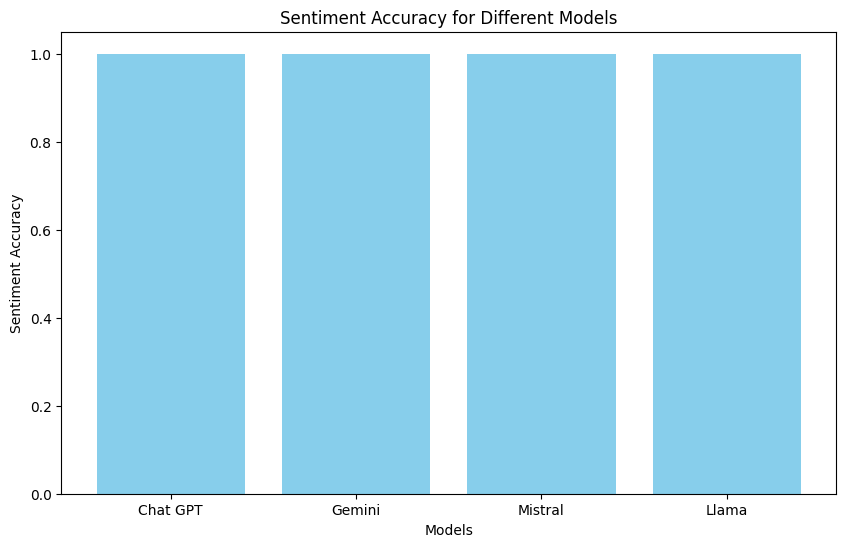

In [21]:
# Create bar plot
plt.figure(figsize=(10, 6))
plt.bar(model_names, similarity_scores)

# Add labels and title
plt.xlabel('Models')
plt.ylabel('Sentiment Accuracy')
plt.title('Sentiment Accuracy for Different Models')

# Show plot
plt.show()


In [23]:
def save_fact_check_accuracy(model_name, similarity_score, output_filename):
    # Create a DataFrame with the model name and fact-checking accuracy
    new_data = {
        'model_name': [model_name],
        'fact_check_acc': [similarity_score]
    }
    new_df = pd.DataFrame(new_data)

    # Save the DataFrame to a CSV file
    new_df.to_csv(output_filename, index=False)

In [25]:
# Iterate over each model and save fact-checking accuracy
for model_name, similarity_score in zip(model_names, similarity_scores):
    output_filename = f"{model_name.lower().replace(' ', '_')}_fact_checking.csv"
    save_fact_check_accuracy(model_name, similarity_score, output_filename)

In [27]:
df_list = []

# Iterate over each model and create DataFrame
for model_name, similarity_score in zip(model_names, similarity_scores):
    # Create a DataFrame for each model
    new_data = {
        'model_name': [model_name],
        'fact_check_acc': [similarity_score]
    }
    df = pd.DataFrame(new_data)
    df_list.append(df)

# Concatenate all DataFrames into one
combined_df = pd.concat(df_list, ignore_index=True)

# Save the combined DataFrame to a CSV file
combined_output_filename = "combined_fact_checking_scores.csv"
combined_df.to_csv(combined_output_filename, index=False)